# Multi-Face identification using CNN


 - In this notebook we will build our facial identification model step by step to recognize four people. Note that we have images in **jpg** format, and we will go throw the details on how to prepare the data (X, y) for our CNN model. We add folder where we put images for people that we don't know to classify them as **unknown**.
 - The model will be trained on images containing faces, what I mean by that is each image contains just the face area. We don't take the background in consideration.
 - What if your images are not like that, well you have to options:
     - Manually resized them.
     - Use face cascade classifier to extract the face part from each image and save them. Watch this video and stop at the 16th minute : https://www.youtube.com/watch?v=PmZ29Vta7Vc&ab_channel=CodingEntrepreneurs. This classifier may miss some faces, and what we did is manually resize the missed images. 

 - You may ask yourself why all this. The model we run on real-time, for each video frame, we will first extract the faces using face cascade, say 5 faces, and run prediction on those faces and show all the 5 prediction.
 
First let's import some libraries :

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import randrange, uniform

    
   - We will set the image shape to 64x64.
   - DATACROP : directory where we have four folders, each one contains images for each person.
   - CATEGORIES : name of the four folders(people).
   - One example: **"../DATACROP/AL JADD/myimage.jpg"**.
   - Look where I put the directory next to the jupyter notebook:
<img src="dire.png">
<img src="5classes.png"  width="500" height="600">
   - I put also the cascades folder used for face cascade on video.

In [21]:
IMG_SIZE = 32
DATACROP = "dataset_crop"
CATEGORIES = ["AL JADD", "Nossaiba", "EL NABAOUI", "YE", "unknown"]

### Data augmentation

   - **Data augmentation** in a technique used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.
   - we will rotate images by **10°** because our model will process images taken by a camera and in our contest, we know if a person stands in front of the camera, his face will not be rotated by a big angle. How you will augmente your data depends on your usecase.

In [22]:
gen = ImageDataGenerator(
        # Rotate images by 10°
        rotation_range=10,
        shear_range=0.01,
        channel_shift_range = 5,
        brightness_range=(0.1, 1),
        horizontal_flip=True,
        # The area left after rotationg image will be filled with same color on image
        fill_mode='nearest')

### Prepare data for keras

 - Now will load images, apply data augmentation and convert them to numpy arrays.


In [23]:
# data : array contains X,y
data = []
for category in CATEGORIES:
    # path for "DATACROP/category" : Example : "dataset_crop/AL JADD/". dataset_crop is our directory.
    path = os.path.join(DATACROP,category) 
    # class_num is the index of category in CATEGORIES, so AL JADD has the index 0
    class_num = CATEGORIES.index(category) 
    for img in tqdm(os.listdir(path)):
        # Image path with its name
        img_path = os.path.join(path,img)
        
        # load image with cv2
        img_colored = cv2.imread(img_path)
        
        # The generator takes batches, the same of a batch is (n, r, g, b) where n is the number of images in the batch,
        #r, g and b are the dimention of each image on the batch.
        # img_colored is one image and by applying the following line of code it will have the shape (1, r, g, b).
        img_expanded = np.expand_dims(img_colored,0)
        
        # This line of code is essential
        aug_iter = gen.flow(img_expanded)
        
        # For each image we will generate 10 images
        aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
        for image in aug_images:
            
             # For each generated image, we will convert it to grayscale and resize it so that the model training will be very
             # fast. Now every image is an array.
            img_gray_aug = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            img_gray_aug_resized = cv2.resize(img_gray_aug, (IMG_SIZE, IMG_SIZE))
            
            # add the image array and the index. The 10 images will have the same class_num because they are generated from
            # the same image. 
            # Example : image1.jpg of "AL JADD" has index 0 because "AL JADD" is the first in CATEGORIES. So the generated 
            # images 1image1.jpg, ..., 10image1.jpg will have the index 0. Those image names are just examples.
            data.append([img_gray_aug_resized, class_num])        

100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [03:43<00:00,  1.07s/it]


### Shuffle the data

  - Remember to shuffle the data so that the model gets diffrent classes in training.

In [24]:
random.shuffle(data)

### One hot for outputs

 - This is very important to understand. In binary classification the y outputs takes two values (0, 1) but, in our case we have five values because class_num vary from 0 to 4. So we will convert y to one hot.
 - y is :
$$y = \begin{bmatrix}0\\
1\\
2\\
3\\
4\\
\end{bmatrix}$$
- y after one hot transformation :
$$y_{one-hot} = \begin{bmatrix}1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1\\
\end{bmatrix}$$

In [25]:
X = []
y = []

for features,label in data:
    X.append(features)
    y.append(label)

# One hot :
y = to_categorical(y)

# Images are on grayscale (a, b) (X shape is (m, a, b) where m number of images) shape. 
# We want (a, b, 1) (X (m, a, b, 1) shape :
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [26]:
print(X.shape)
print(y.shape)

(7210, 32, 32, 1)
(7210, 5)


### Save data as pickle format

 - Always save your data so next time you will just load X and y without repeating the above codes again 

In [27]:
pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

<img src="dire2.png">

### Load data

In [28]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

# Rescale the image. The values will vary from 0 to 1 for fast training
X = X/255.0
print(f'One training example shape: {X.shape[1:]}')
print(f'Output shape: {y.shape[1:]}')

One training example shape: (32, 32, 1)
Output shape: (5,)


### Split data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

### Build the CNN model

In [31]:
model = Sequential()
# The input shape is the image shape (a, b, 1) 'It is grayscale'
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Dropout(0.6))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
#model.add(Dropout(0.6))


model.add(Flatten())

# I have four classes, so make sure to use the right number bellow
model.add(Dense(5, activation='softmax'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train the model

 - Epochs are number of passes on the entire dataset. The model will pass 5 times on the dataset. In each epoch, it will takes 20 images (batch_size)

In [32]:
model.fit(X_train, y_train, batch_size=20, epochs=5, validation_split=0.4)

Epoch 1/5
130/130 [==============================] - 28s 208ms/step - loss: 0.3701 - accuracy: 0.5511 - val_loss: 0.1178 - val_accuracy: 0.9295
Epoch 2/5
130/130 [==============================] - 28s 213ms/step - loss: 0.1242 - accuracy: 0.9214 - val_loss: 0.0882 - val_accuracy: 0.9451
Epoch 3/5
130/130 [==============================] - 28s 215ms/step - loss: 0.0645 - accuracy: 0.9595 - val_loss: 0.0455 - val_accuracy: 0.9752
Epoch 4/5
130/130 [==============================] - 28s 215ms/step - loss: 0.0401 - accuracy: 0.9788 - val_loss: 0.0399 - val_accuracy: 0.9798
Epoch 5/5
130/130 [==============================] - 28s 217ms/step - loss: 0.0352 - accuracy: 0.9842 - val_loss: 0.0262 - val_accuracy: 0.9896


### Evaluate the model on the test set

In [33]:
model.evaluate(X_test, y_test)

# If the model suffer from overfitting, try to change CNN architecture by adding Droput layers ... 
# You may spend a lot time retraining your model. DO NOT BE SAD! ... You have to know what your model suffer from, and try to 
# solve the problem.

91/91 [==============================] - 5s 51ms/step - loss: 0.0371 - accuracy: 0.9806


[0.03709942102432251, 0.9805825352668762]

### Save the model in h5 format

 - Always save !!!

In [34]:
model.save("my_model.h5")

### Load the model

In [35]:
new_model = load_model("my_model.h5")
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 26, 26, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 conv2d_9 (Conv2D)           (None, 22, 22, 64)        73792     
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 32)       

In [36]:
# Make prediction from X_test:
# I will set threshold = 0.5 so if the model gives for example 0.4 probability that an image belongs to a class, I will consider
# not taking it into consideration
def predict_from_X(i, threshold):
    x = X_test[i]
    plt.imshow(x)
    x = np.expand_dims(x, axis=0)
    prediction = new_model.predict(x)
    i  =  np.array(np.where(((prediction >= threshold).astype('int32')[0]) == 1))[0]
    who = ""
    
    if i.shape == (0,):
        who = "Person not recognized"
    else:
        
        if i[0] == 0:
            who = "AL JADD"

        elif i[0] == 1:
            who = "Nossaiba"

        elif i[0] == 2:
            who = "EL NABAOUI"

        elif i[0] == 3:
            who = "YE Langze"
        else:
            pass
    print(who)
    plt.show()

In [37]:
# Make prediction from X_test:
# I will set threshold = 0.5 so if the model gives for example 0.4 probability that an image belongs to a class, I will consider
# not taking it into consideration
def predict_from_X(i, threshold):
    x = X_test[i]
    plt.imshow(x)
    x = np.expand_dims(x, axis=0)
    prediction = new_model.predict(x)
    i  =  np.array(np.where(((prediction >= threshold).astype('int32')[0]) == 1))[0]
    who = ""
    
    if not i.shape == (0,):
        if i[0] == 0:
                who = "AL JADD"

        elif i[0] == 1:
            who = "Nossaiba"

        elif i[0] == 2:
            who = "EL NABAOUI"

        elif i[0] == 3:
            who = "YE Langze"
        else:
            who = "Unknown"
    else:
        who = "Unknown"
    print(who)
    plt.show()

Unknown


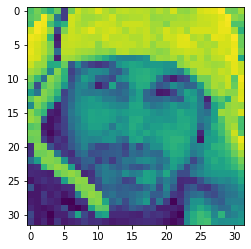

In [38]:
predict_from_X(randrange(0, X_test.shape[0]-1), threshold=0.8)

## Real time test

In [39]:
# Make prediction from image (jpg format ...):
def predict_from_frame(image, threshold):
    image = np.expand_dims(image, axis=0)
    prediction = new_model.predict(image)
    i  =  np.array(np.where(((prediction >= threshold).astype('int32')[0]) == 1))[0]
    who = ""
    if not i.shape == (0,):
        if i[0] == 0:
                who = "AL JADD"

        elif i[0] == 1:
            who = "Nossaiba"

        elif i[0] == 2:
            who = "EL NABAOUI"

        elif i[0] == 3:
            who = "YE Langze"
        else:
            who = "Unknown"
    else:
        who = "Unknown"
    return who

In [40]:
from time import time
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
last_time = time()
face_cascade = cv2.CascadeClassifier("cascades/data/haarcascade_frontalface_default.xml")

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=2, minNeighbors=1)
    for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_sav = frame[y:y+h, x:x+w]
            resized_roi_gray = cv2.resize(roi_gray, (IMG_SIZE, IMG_SIZE))
            # When you wanna make prediction, you have to rescale the image first. I pass two days figuring out why my model
            # outputing the same result. As the model was trained on rescaled images, the prediction must done on rescaled
            # images too.
            resized_roi_gray_recaled = resized_roi_gray/255.0
            
            color = (255, 0, 0) 
            stroke = 2
            end_cord_x = x + w
            end_cord_y = y + h 
            cv2.rectangle(frame, (x, y), (end_cord_x, end_cord_y), color, stroke)
            
            p = predict_from_frame(resized_roi_gray_recaled, threshold=0.8)   
            cv2.putText(frame, p , (x,y), font, 1, (0, 0, 255), 1, cv2.LINE_4)
          
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()